# FlexzBoost on cosmoDC2 gold test set

<span style="font-size:22px;"> Author: Iago Lopes Soares Dias<br>
Email: iagolops2012@gmail.com</span>


In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables_io
import qp
import sys


from matplotlib import gridspec
import seaborn as sns
from qp.metrics.pit import PIT
from IPython.display import Markdown
import h5py
import os
from qp.ensemble import Ensemble
from qp import interp


from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator
from rail.evaluation.metrics.base import MetricEvaluator
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle, DataHandle
from rail.core.util_stages import ColumnMapper, TableConverter
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer

import warnings
warnings.filterwarnings("ignore")


## Reading data

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [3]:

training_o = tables_io.read('cosmodc2_140k_gold_trainingset.hdf5')
validation_o = tables_io.read('cosmodc2_140k_gold_testset.hdf5')


In [4]:
training_csv = pd.DataFrame(training_o['photometry'])
validation_csv = pd.DataFrame(validation_o['photometry'])

In [5]:

data = pd.concat([training_csv,validation_csv],axis=0)
data = data.reset_index(drop=True)

In [6]:
data = data[data['mag_i_lsst']<25]

In [7]:
data

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
0,0.435994,0.007072,1250000000,0.164345,0.007072,0.005001,0.005000,0.005000,0.005017,0.005001,...,17.062208,15.137871,15.244094,0.014800,0.259352,0.007071,0.958424,0.007083,0.106223,0.007072
1,0.439835,0.012676,1250000225,0.090141,0.014104,0.010262,0.008135,0.007441,0.131178,0.023148,...,24.718765,22.663742,22.714552,0.048879,0.233574,0.011025,1.240664,0.131579,0.050810,0.025856
2,0.330523,0.008828,1250000450,0.039524,0.009960,0.006645,0.006154,0.005813,0.056329,0.014314,...,23.789845,22.090605,22.109261,0.047392,0.184605,0.008465,1.125933,0.056719,0.018656,0.016316
3,0.427570,0.009876,1250000675,0.102930,0.010689,0.007698,0.006572,0.006186,0.073198,0.015032,...,24.079102,22.151592,22.242300,0.072630,0.224634,0.009025,1.081667,0.073602,0.090708,0.017235
4,0.686884,0.007932,1250000900,0.181633,0.007676,0.005943,0.005278,0.005254,0.052234,0.007050,...,23.706137,20.985334,21.085735,0.066845,0.348433,0.007447,1.403452,0.052571,0.100401,0.008988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285336,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,0.129267,...,24.674099,24.564243,24.624903,2.557191,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
285337,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,0.164621,...,24.415499,24.827410,24.705545,2.616157,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
285338,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,0.114559,...,25.356873,24.432663,24.294462,2.694391,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759
285339,0.125515,0.055764,12019512222,0.238531,0.079680,0.043097,0.045896,0.035388,26.620825,0.198862,...,99.000000,25.032970,24.722982,2.877230,0.115925,0.057954,73.797043,26.620859,-0.309988,0.209257


## Removing mag 99 and bright objects
 Trying to see if the cut in u band makes difference

In [8]:
bands = ['u','g','r','i','z','y']
limits = []
for band in bands:
    training_csv = training_csv[training_csv[f'mag_{band}_lsst']<99]
    training_csv = training_csv[training_csv[f'mag_{band}_lsst']>16]
    #training_csv = training_csv[training_csv['mag_u_lsst']<31]
    #training_csv = training_csv[training_csv['mag_err_u_lsst']<18]
    validation_csv = validation_csv[validation_csv[f'mag_{band}_lsst']<99]
    validation_csv = validation_csv[validation_csv[f'mag_{band}_lsst']>16]
    #validation_csv = validation_csv[validation_csv['mag_u_lsst']<31]
    #validation_csv = validation_csv[validation_csv['mag_err_u_lsst']<18]
    data = data[data[f'mag_{band}_lsst']<99]
    data = data[data[f'mag_{band}_lsst']>16]
    #data = data[data['mag_u_lsst']<31]
    #data = data[data['mag_err_u_lsst']<18]
    limits.append(max(data[f'mag_{band}_lsst']))

In [9]:
limits = np.round(limits,4)
limits

array([34.9348, 29.6312, 26.9223, 25.    , 25.4012, 26.1534])

In [10]:
len(training_csv)+len(validation_csv)==len(data)

True

In [11]:
validation_csv

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
1,0.315699,0.007944,1312500225,0.077675,0.008477,0.005824,0.005575,0.005403,0.033321,0.009905,...,23.202431,21.592501,21.638060,0.030609,0.185198,0.007763,0.985800,0.033827,0.045559,0.011785
2,0.174147,0.033231,1312500450,0.122187,0.047875,0.026059,0.025786,0.020620,0.306728,0.097963,...,25.644894,24.262041,24.195457,0.045475,0.147116,0.033017,1.005987,0.307833,-0.066584,0.105942
3,0.275715,0.013911,1312500675,0.048395,0.018623,0.010965,0.010116,0.008561,0.123833,0.032323,...,24.655771,23.041840,23.107073,0.065590,0.142187,0.013252,1.082401,0.124318,0.065233,0.035906
4,0.434650,0.056377,1312500900,0.127439,0.064814,0.047869,0.034883,0.029781,0.498633,0.127012,...,26.173477,24.545084,24.529957,0.065404,0.227051,0.045866,0.854380,0.500925,-0.015127,0.138261
5,0.409700,0.014604,1312501125,0.089149,0.016855,0.011905,0.009458,0.008458,0.155537,0.028244,...,24.904810,22.890232,22.965204,0.052629,0.222832,0.012689,1.217924,0.155992,0.074972,0.031501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141347,0.306469,0.057675,12016611194,-0.171865,0.091578,0.047302,0.039958,0.032999,3.383940,0.170498,...,28.253912,24.865582,24.980207,2.537769,0.191120,0.051823,2.947981,3.384271,0.114626,0.189366
141348,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,0.129267,...,24.674099,24.564243,24.624903,2.557191,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
141349,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,0.164621,...,24.415499,24.827410,24.705545,2.616157,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
141350,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,0.114559,...,25.356873,24.432663,24.294462,2.694391,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759


In [12]:
training_csv

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
1,0.439835,0.012676,1250000225,0.090141,0.014104,0.010262,0.008135,0.007441,0.131178,0.023148,...,24.718765,22.663742,22.714552,0.048879,0.233574,0.011025,1.240664,0.131579,0.050810,0.025856
2,0.330523,0.008828,1250000450,0.039524,0.009960,0.006645,0.006154,0.005813,0.056329,0.014314,...,23.789845,22.090605,22.109261,0.047392,0.184605,0.008465,1.125933,0.056719,0.018656,0.016316
3,0.427570,0.009876,1250000675,0.102930,0.010689,0.007698,0.006572,0.006186,0.073198,0.015032,...,24.079102,22.151592,22.242300,0.072630,0.224634,0.009025,1.081667,0.073602,0.090708,0.017235
4,0.686884,0.007932,1250000900,0.181633,0.007676,0.005943,0.005278,0.005254,0.052234,0.007050,...,23.706137,20.985334,21.085735,0.066845,0.348433,0.007447,1.403452,0.052571,0.100401,0.008988
5,0.450312,0.010420,1250001125,0.110182,0.011242,0.008228,0.006840,0.006393,0.088221,0.016275,...,24.284307,22.248983,22.337086,0.066775,0.224833,0.009363,1.161896,0.088604,0.088102,0.018560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143982,0.158178,0.042341,12079903066,-0.050531,0.084528,0.033074,0.040267,0.026437,0.333419,0.170297,...,25.735693,24.864300,24.867409,2.603548,-0.066914,0.048170,0.827551,0.335055,0.003109,0.185809
143983,0.034594,0.024981,12080478115,-0.020531,0.048508,0.018605,0.023807,0.016671,0.133943,0.102961,...,24.741558,24.316311,24.247107,2.673244,-0.013557,0.029064,0.493946,0.135229,-0.069204,0.111298
143985,0.313023,0.059877,12080518338,0.036747,0.093516,0.049209,0.047269,0.034114,0.438292,0.179264,...,26.033213,24.920122,24.957283,2.666754,0.042526,0.058293,0.683634,0.441046,0.037161,0.196587
143986,0.093676,0.010483,12081970095,-0.091150,0.016780,0.007764,0.008654,0.007044,0.062337,0.033331,...,23.901955,23.076199,23.002985,2.887300,0.008501,0.011158,0.887943,0.062818,-0.073214,0.036299


## Functions

In [13]:
def plot_redshift(catalog):
    plt.figure(figsize=(8,8))
    plt.hist(catalog['redshift'],bins=201,density=True,color='red')
    plt.xlabel('Redshift', fontsize=13)
    plt.ylabel('Normalized Counts', fontsize=13)
    plt.show()

In [14]:
def plot_errors(catalog):
    bands = ['u', 'g', 'r', 'i', 'z', 'y']
    j=1
    plt.figure(figsize=[9,13])
    for i, band in enumerate(bands):

        plt.subplot(3,2,j) 
        mag = np.array(catalog[f'mag_{band}_lsst'])
        err = np.array(catalog[f'mag_err_{band}_lsst'])
        sn = 1/(10**(0.4*err)-1)
        plt.hexbin(mag,sn , None, mincnt=1, cmap='inferno', gridsize=[400,200], bins='log')
        cbar = plt.colorbar()
        plt.ylabel("S/R ", fontsize=13)
        plt.xlabel("mag "+band, fontsize=13)
        plt.ylim(0,100)
        plt.xlim(20,30)
        plt.axhline(10, color= 'red')
        plt.grid(True)
        j+=1
        plt.tight_layout()

In [15]:
def mag_histogram(catalog, title='DP0.2'):
    
    bands = ['u','g', 'r', 'i', 'z','y']
    colors = ['blue', 'green', 'orange','red','purple','gray']
    plt.figure(figsize=(9,13))
    bins = np.linspace(9, 37, 57)
    j=1
    for i, (band, color) in enumerate(zip(bands,colors)):
        plt.subplot(3,2,j)
        plt.hist(catalog[f'mag_{band}_lsst'], histtype='stepfilled', bins=bins, label=f'{band} band', alpha = 0.5,
                 edgecolor = "black", color = color)
        #plt.xlim(16,27)
        plt.yscale('log')
        plt.xlabel('mag',fontsize=13)
        plt.ylabel('counts',fontsize=13)
        plt.legend(loc=2)
        plt.grid(True)
        j+=1
    plt.suptitle(title)
    plt.show()


In [16]:
def mag_color(catalog):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    mag_diff = {}
    plt.figure(figsize=(9,13))
    i=1
    for band,_band in zip(bands, bands[1::]):
        plt.subplot(3,2,i)
        i+=1
        mag_diff_v = catalog[f'mag_{band}_lsst']-catalog[f'mag_{_band}_lsst']
        mag_v = catalog[f'mag_{band}_lsst'] 
                   
        plt.hexbin(mag_v, mag_diff_v, None, mincnt=1, cmap='Reds', gridsize=[400,400], bins='log')

        plt.xlabel("mag "+band,fontsize=13)
        plt.ylabel(f"{band}-{_band}",fontsize=13)
        #plt.legend()
        plt.xlim(16,32)
        plt.ylim(-2,5)
        plt.grid(True)
        plt.tight_layout()
    plt.show()

In [17]:
def cor_cor(catalog):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        plt.hist2d(past_color-color,color-next_color, bins = 100, cmap='turbo' )
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        #plt.axvline(0)
        #plt.axhline(0)
    plt.show()

In [18]:
def color_color(catalog):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, None, mincnt=1, cmap='turbo', gridsize=[400,400], bins='log')
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar()
        plt.xlim(-1,3)
        plt.ylim(-1,3)
    plt.show()

In [19]:
def color_color_red(catalog,xlim=[-1,3],ylim=[-1,3]):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, C=catalog['redshift'], mincnt=1, cmap='RdYlBu', gridsize=[150,75],reduce_C_function=np.std,vmax=0.4)
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar(label='redshift')
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
    plt.show()

## EXTRA with Bruno

In [20]:
data_f = pd.read_csv('sample_cosmodc2_w10year_errors.dat', sep =' ')

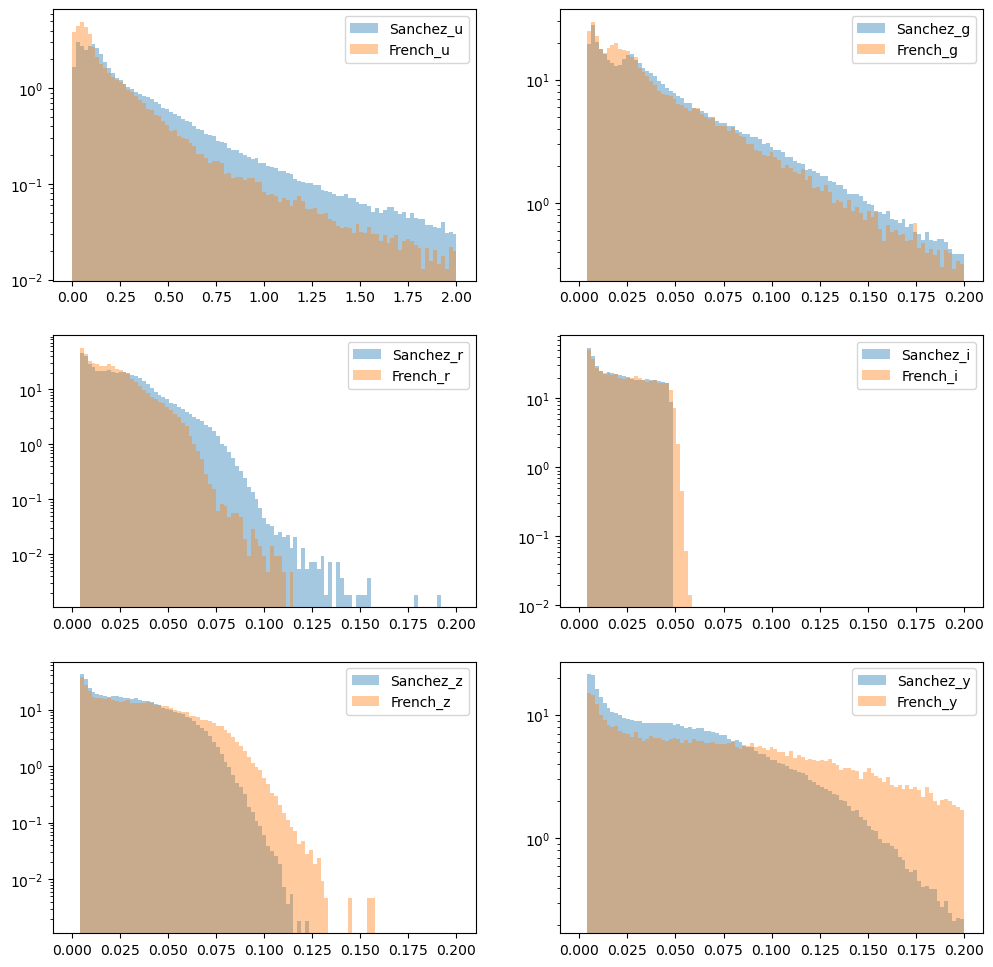

In [21]:
bands = ['u', 'g', 'r', 'i', 'z','y']
i=1
plt.figure(figsize=(12,12))
for band in bands:
    plt.subplot(3,2,i)
    if band == 'u':
        bins = np.linspace(0,2,100)
    else:
        bins=np.linspace(0,0.2,100)
    plt.hist(data[f'mag_err_{band}_lsst'],label=f'Sanchez_{band}',alpha=0.4,bins=bins,density=True)
    plt.hist(data_f[f'{band}err'],label=f'French_{band}',alpha=0.4,bins=bins,density=True)
    plt.legend()
    plt.yscale('log')
    i+=1
plt.show()

## Plots

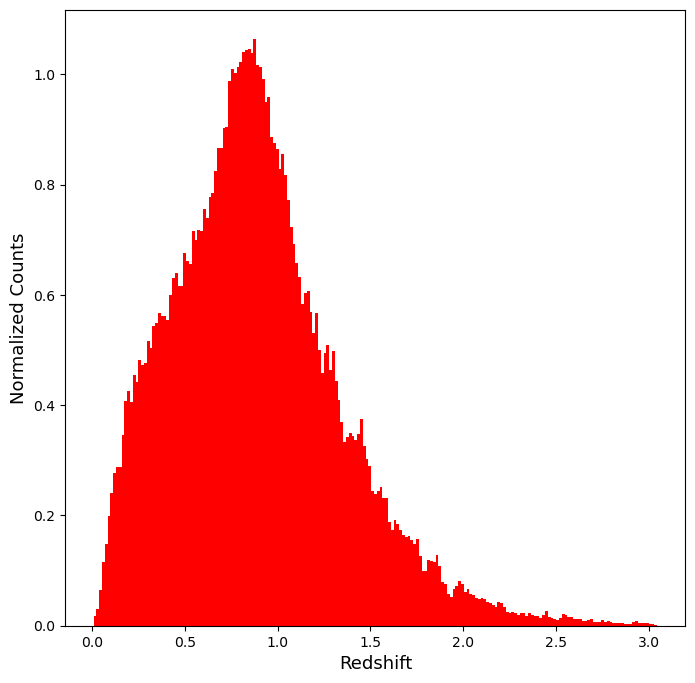

In [22]:
plot_redshift(data)

97.57510375976562
2.511800527572632
0.19084672629833221
0.04752539098262787
0.12121924012899399
0.5576127171516418


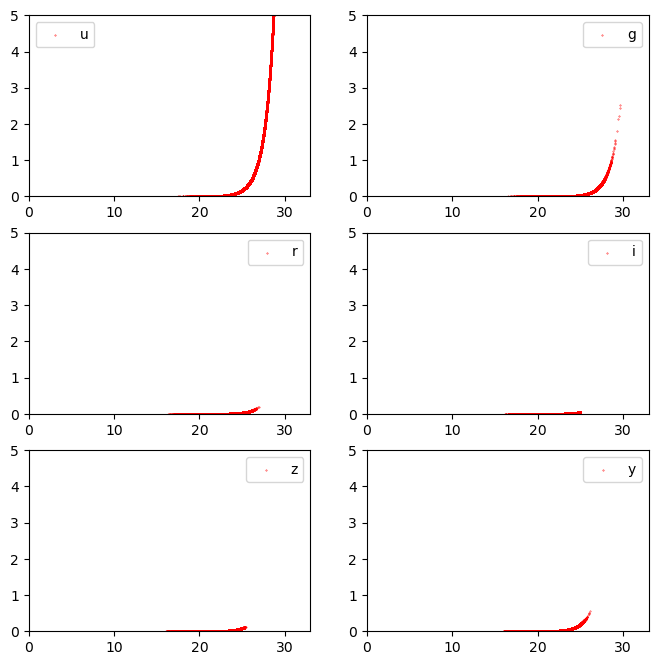

In [23]:
bands=['u','g','r','i','z','y']
i=1
plt.figure(figsize=(8,8))
for band in bands:
    print(max(data[f'mag_err_{band}_lsst']))
    plt.subplot(3,2,i)
    plt.scatter(data[f'mag_{band}_lsst'],data[f'mag_err_{band}_lsst'],s=0.1,color='red',label=band)
    plt.legend()
    plt.ylim(0,5)
    plt.xlim(0,33)
    i+=1

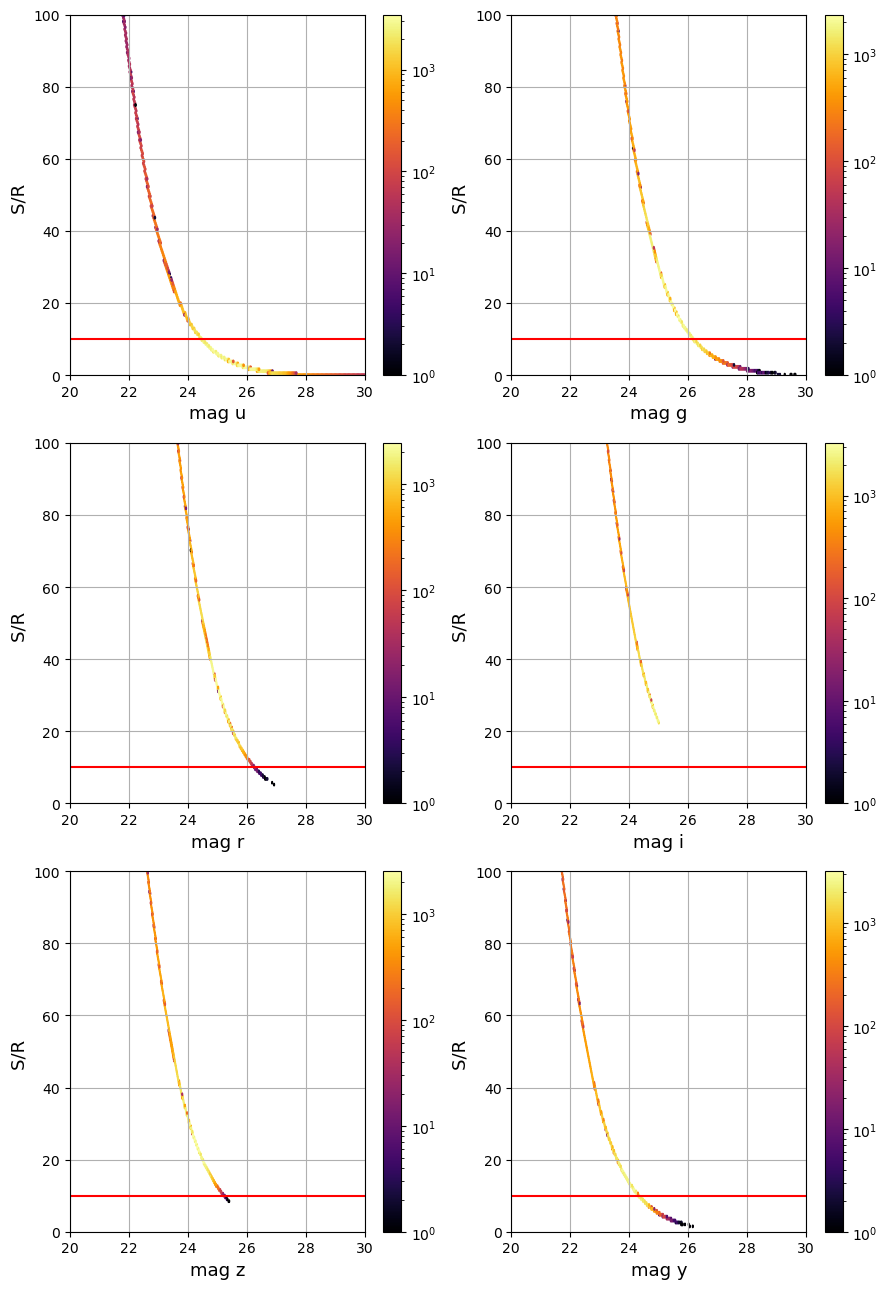

In [24]:
plot_errors(data)

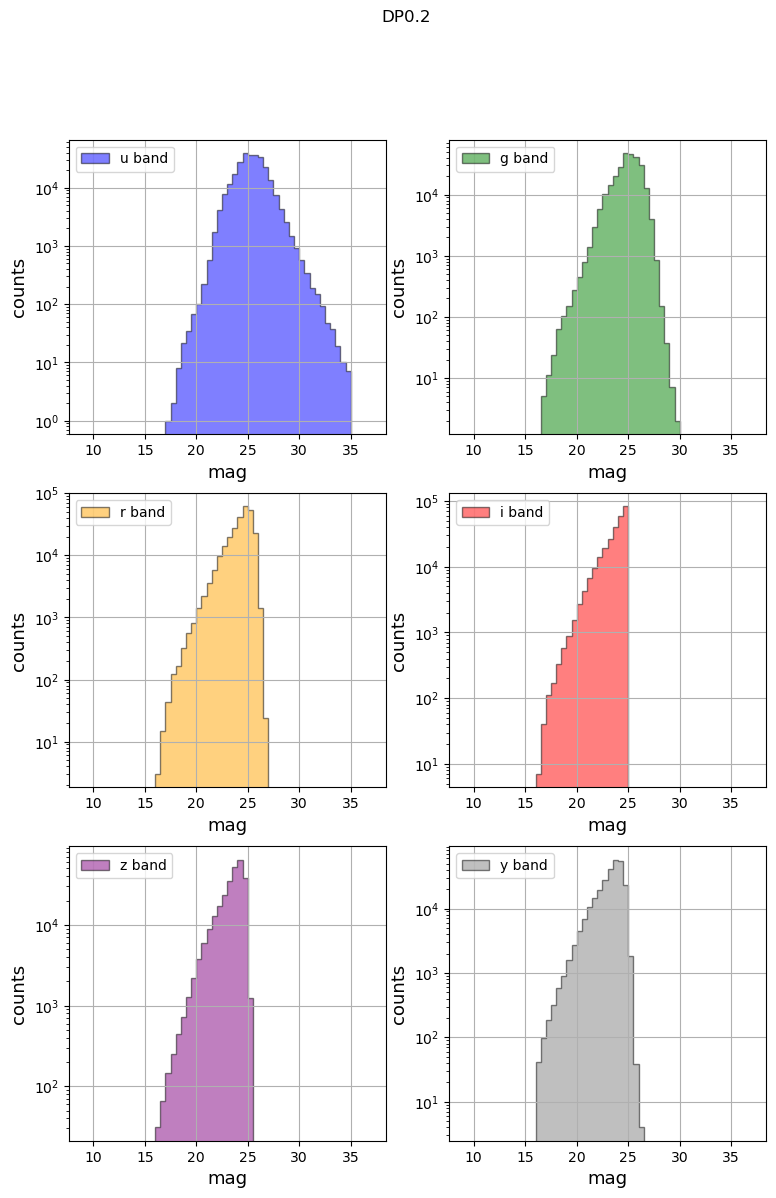

In [25]:
mag_histogram(data)

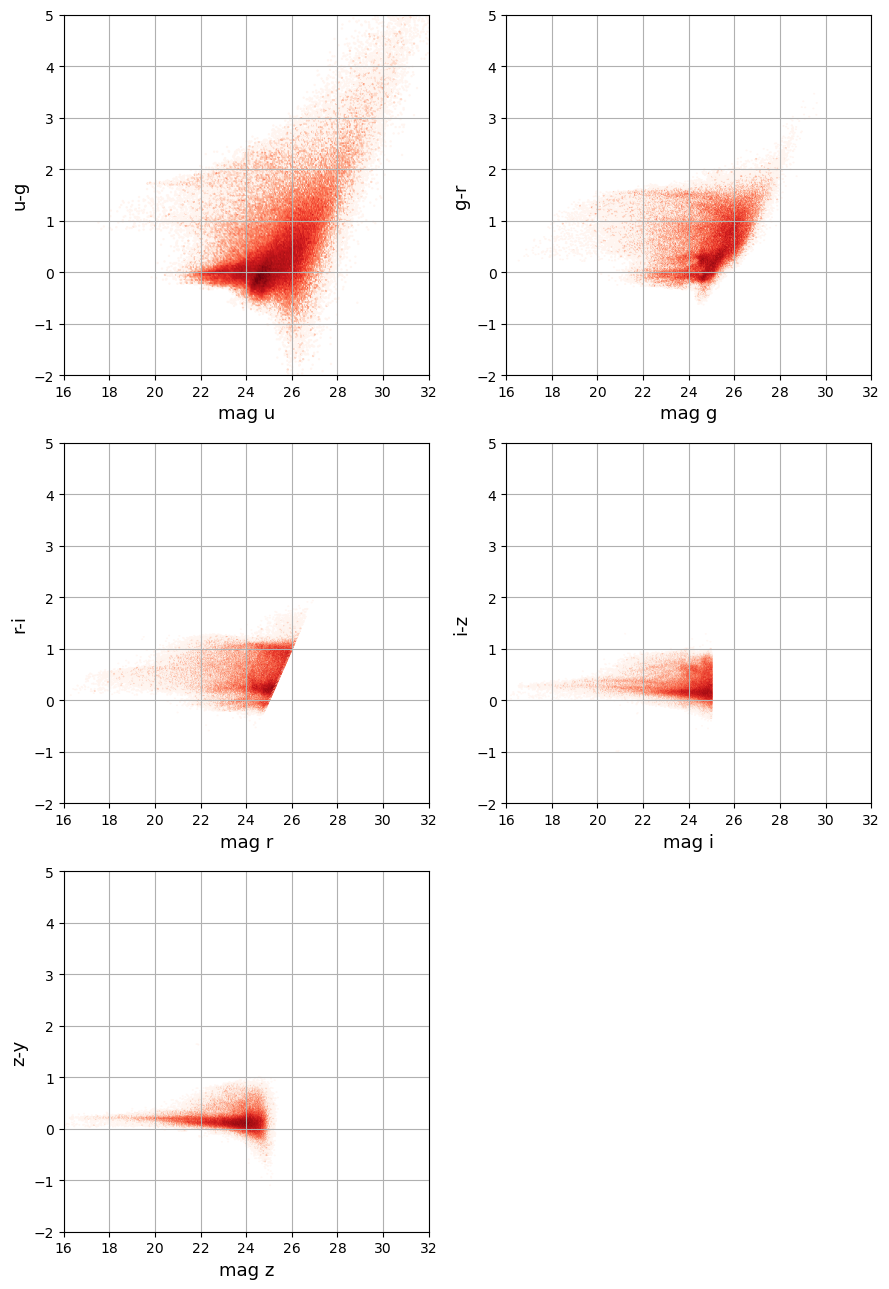

In [26]:
mag_color(data)

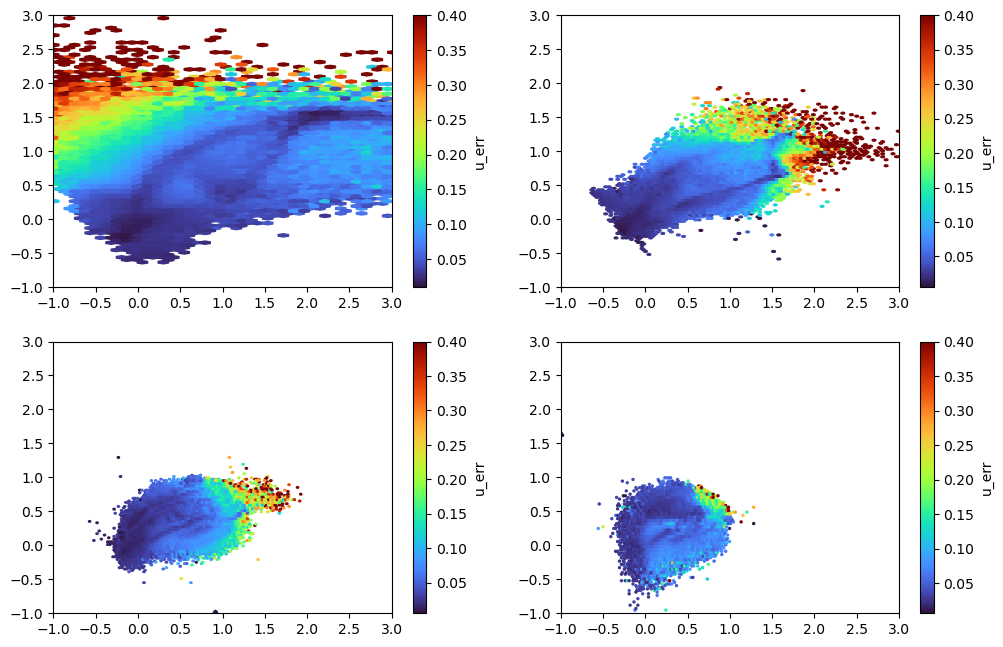

In [27]:
bands = ['u', 'g', 'r', 'i', 'z','y']
i=1
plt.figure(figsize=(12,12))
for index in range(len(bands)-2):
    plt.subplot(3,2,i)
    i+=1
    color = data[f'mag_{bands[index+1]}_lsst']
    next_color = data[f'mag_{bands[index+2]}_lsst']
    past_color = data[f'mag_{bands[index]}_lsst']
        
    plt.hexbin(past_color-color,color-next_color, C=data['mag_err_g_lsst'], mincnt=1, cmap='turbo',vmax=0.4)
    c=plt.colorbar(label='u_err')
    plt.xlim(-1,3)
    plt.ylim(-1,3)
plt.show()

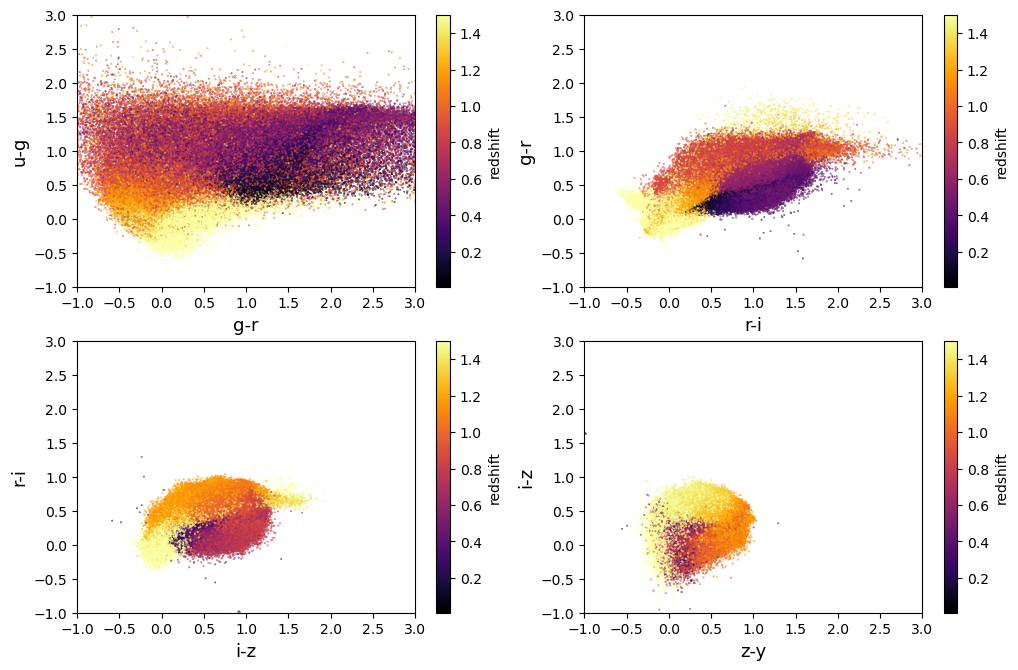

In [28]:
xlim=[-1,3]
ylim=[-1,3]
bands = ['u', 'g', 'r', 'i', 'z','y']
i=1
plt.figure(figsize=(12,12))
for index in range(len(bands)-2):
    plt.subplot(3,2,i)
    i+=1
    color = data[f'mag_{bands[index+1]}_lsst']
    next_color = data[f'mag_{bands[index+2]}_lsst']
    past_color = data[f'mag_{bands[index]}_lsst']
        
    plt.scatter(past_color-color,color-next_color, c=data['redshift'], cmap='inferno',s=0.1,vmax=1.5)
    plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
    plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
    cbar = plt.colorbar(label='redshift')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])

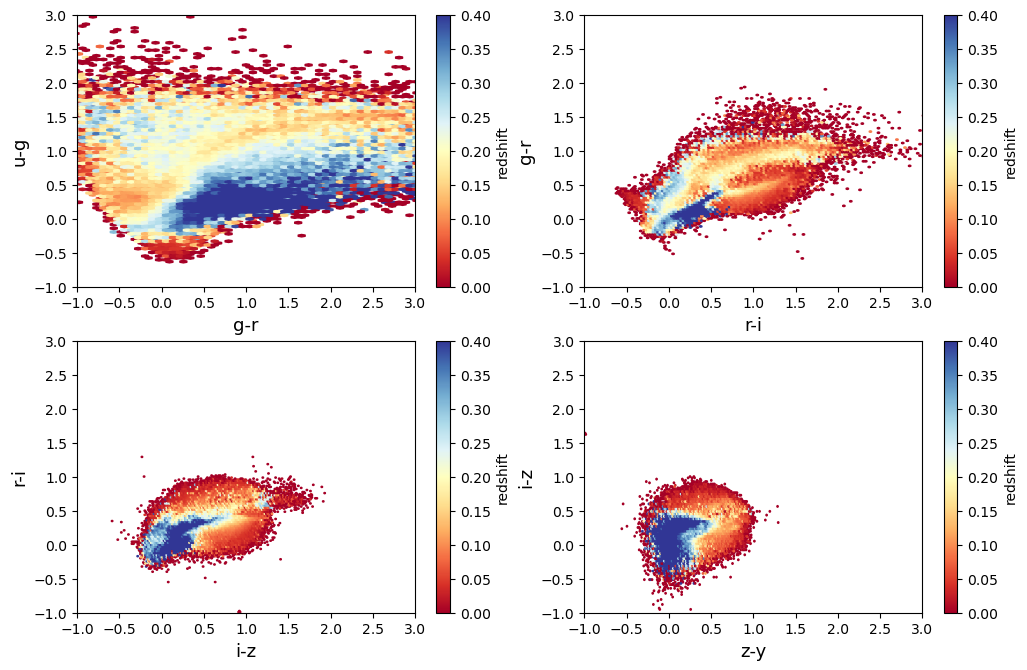

In [29]:
color_color_red(data)

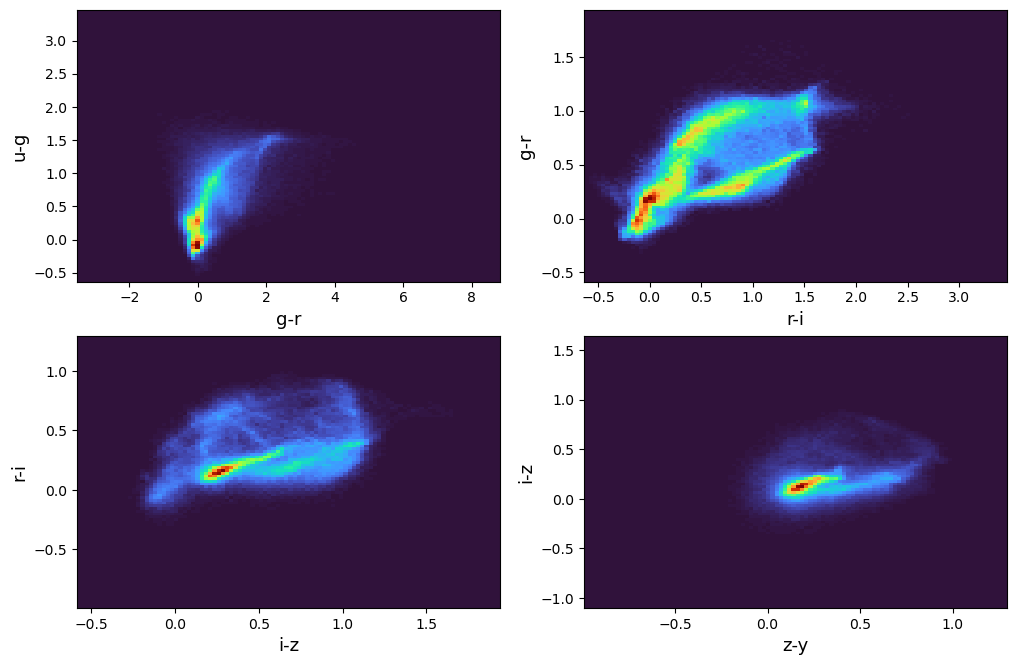

In [30]:
cor_cor(data)

## Getting the maximum and minimum redshift from training sample for FlexzBoost configurations

In [31]:

z_max = max(data['redshift'])
z_min = min(data['redshift'])


## Choosing training fraction (only if you want mix both catalogs)

In [32]:
fraction = 0.5 # choose a value between 0 and 1

training_csv = data.sample(round(len(data)*fraction),random_state=40)
validation_csv = data.drop(training_csv.index)#Changing-the-data-to-a-PqHandle

In [33]:
training_csv = training_csv.sort_index()
training_csv

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
2,0.330523,0.008828,1250000450,0.039524,0.009960,0.006645,0.006154,0.005813,0.056329,0.014314,...,23.789845,22.090605,22.109261,0.047392,0.184605,0.008465,1.125933,0.056719,0.018656,0.016316
3,0.427570,0.009876,1250000675,0.102930,0.010689,0.007698,0.006572,0.006186,0.073198,0.015032,...,24.079102,22.151592,22.242300,0.072630,0.224634,0.009025,1.081667,0.073602,0.090708,0.017235
5,0.450312,0.010420,1250001125,0.110182,0.011242,0.008228,0.006840,0.006393,0.088221,0.016275,...,24.284307,22.248983,22.337086,0.066775,0.224833,0.009363,1.161896,0.088604,0.088102,0.018560
6,0.617985,0.079133,1250001350,-0.049755,0.090697,0.070071,0.043201,0.036770,0.661469,0.188904,...,26.480690,24.977093,24.944443,0.069720,0.225378,0.056730,0.742640,0.665170,-0.032650,0.205047
7,0.323547,0.021854,1250001575,0.067120,0.027734,0.017797,0.014710,0.012683,0.154538,0.056996,...,24.897776,23.669611,23.588627,0.066236,0.215302,0.019423,0.703180,0.155560,-0.080984,0.061655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285335,0.306469,0.057675,12016611194,-0.171865,0.091578,0.047302,0.039958,0.032999,3.383940,0.170498,...,28.253912,24.865582,24.980207,2.537769,0.191120,0.051823,2.947981,3.384271,0.114626,0.189366
285336,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,0.129267,...,24.674099,24.564243,24.624903,2.557191,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
285337,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,0.164621,...,24.415499,24.827410,24.705545,2.616157,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
285338,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,0.114559,...,25.356873,24.432663,24.294462,2.694391,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759


In [34]:
validation_csv

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
1,0.439835,0.012676,1250000225,0.090141,0.014104,0.010262,0.008135,0.007441,0.131178,0.023148,...,24.718765,22.663742,22.714552,0.048879,0.233574,0.011025,1.240664,0.131579,0.050810,0.025856
4,0.686884,0.007932,1250000900,0.181633,0.007676,0.005943,0.005278,0.005254,0.052234,0.007050,...,23.706137,20.985334,21.085735,0.066845,0.348433,0.007447,1.403452,0.052571,0.100401,0.008988
8,0.821104,0.008080,1250001800,0.258137,0.007588,0.006143,0.005258,0.005250,0.066221,0.006616,...,23.968679,20.829702,20.963223,0.090233,0.384127,0.007430,1.542089,0.066505,0.133520,0.008585
9,0.323227,0.007292,1250002025,0.050388,0.007440,0.005213,0.005147,0.005099,0.015634,0.006471,...,22.306936,20.769371,20.818016,0.087465,0.154305,0.007245,0.961000,0.016480,0.048645,0.008411
11,0.276882,0.018048,1250002704,0.089479,0.023706,0.014423,0.012866,0.010850,0.156252,0.042608,...,24.909821,23.349073,23.396112,0.080933,0.174328,0.016830,0.973019,0.156916,0.047039,0.047030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285322,-0.073339,0.033419,12013625669,-0.176102,0.082319,0.023855,0.035856,0.023405,0.108945,0.169864,...,24.515617,24.861525,24.864143,2.133048,-0.076967,0.042819,-0.022118,0.111526,0.002619,0.185323
285324,-0.043240,0.011217,12013667540,-0.050415,0.021861,0.008067,0.011054,0.007794,0.034937,0.043869,...,23.256037,23.381330,23.332359,2.157745,-0.152248,0.013525,0.169580,0.035856,-0.048971,0.047751
285325,0.001255,0.008378,12013670472,-0.067448,0.012157,0.006014,0.006854,0.005832,0.018630,0.020360,...,22.524033,22.515205,22.519764,2.154290,-0.103863,0.009000,0.174324,0.019576,0.004559,0.022702
285329,-0.152683,0.023864,12014281333,-0.195494,0.061214,0.016482,0.026441,0.017257,0.078769,0.128278,...,24.159809,24.555883,24.541622,2.200826,-0.091518,0.031575,0.057882,0.080475,-0.014261,0.139654


## Changing the data to a PqHandle

In [35]:
training_sample = DS.add_data(data=training_csv, handle_class=PqHandle, key='redshift')
validation_sample = DS.add_data(data=validation_csv, handle_class=PqHandle, key='redshift')

In [36]:
training_sample.data

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
2,0.330523,0.008828,1250000450,0.039524,0.009960,0.006645,0.006154,0.005813,0.056329,0.014314,...,23.789845,22.090605,22.109261,0.047392,0.184605,0.008465,1.125933,0.056719,0.018656,0.016316
3,0.427570,0.009876,1250000675,0.102930,0.010689,0.007698,0.006572,0.006186,0.073198,0.015032,...,24.079102,22.151592,22.242300,0.072630,0.224634,0.009025,1.081667,0.073602,0.090708,0.017235
5,0.450312,0.010420,1250001125,0.110182,0.011242,0.008228,0.006840,0.006393,0.088221,0.016275,...,24.284307,22.248983,22.337086,0.066775,0.224833,0.009363,1.161896,0.088604,0.088102,0.018560
6,0.617985,0.079133,1250001350,-0.049755,0.090697,0.070071,0.043201,0.036770,0.661469,0.188904,...,26.480690,24.977093,24.944443,0.069720,0.225378,0.056730,0.742640,0.665170,-0.032650,0.205047
7,0.323547,0.021854,1250001575,0.067120,0.027734,0.017797,0.014710,0.012683,0.154538,0.056996,...,24.897776,23.669611,23.588627,0.066236,0.215302,0.019423,0.703180,0.155560,-0.080984,0.061655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285335,0.306469,0.057675,12016611194,-0.171865,0.091578,0.047302,0.039958,0.032999,3.383940,0.170498,...,28.253912,24.865582,24.980207,2.537769,0.191120,0.051823,2.947981,3.384271,0.114626,0.189366
285336,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,0.129267,...,24.674099,24.564243,24.624903,2.557191,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
285337,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,0.164621,...,24.415499,24.827410,24.705545,2.616157,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
285338,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,0.114559,...,25.356873,24.432663,24.294462,2.694391,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759


In [37]:
validation_sample.data

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
1,0.439835,0.012676,1250000225,0.090141,0.014104,0.010262,0.008135,0.007441,0.131178,0.023148,...,24.718765,22.663742,22.714552,0.048879,0.233574,0.011025,1.240664,0.131579,0.050810,0.025856
4,0.686884,0.007932,1250000900,0.181633,0.007676,0.005943,0.005278,0.005254,0.052234,0.007050,...,23.706137,20.985334,21.085735,0.066845,0.348433,0.007447,1.403452,0.052571,0.100401,0.008988
8,0.821104,0.008080,1250001800,0.258137,0.007588,0.006143,0.005258,0.005250,0.066221,0.006616,...,23.968679,20.829702,20.963223,0.090233,0.384127,0.007430,1.542089,0.066505,0.133520,0.008585
9,0.323227,0.007292,1250002025,0.050388,0.007440,0.005213,0.005147,0.005099,0.015634,0.006471,...,22.306936,20.769371,20.818016,0.087465,0.154305,0.007245,0.961000,0.016480,0.048645,0.008411
11,0.276882,0.018048,1250002704,0.089479,0.023706,0.014423,0.012866,0.010850,0.156252,0.042608,...,24.909821,23.349073,23.396112,0.080933,0.174328,0.016830,0.973019,0.156916,0.047039,0.047030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285322,-0.073339,0.033419,12013625669,-0.176102,0.082319,0.023855,0.035856,0.023405,0.108945,0.169864,...,24.515617,24.861525,24.864143,2.133048,-0.076967,0.042819,-0.022118,0.111526,0.002619,0.185323
285324,-0.043240,0.011217,12013667540,-0.050415,0.021861,0.008067,0.011054,0.007794,0.034937,0.043869,...,23.256037,23.381330,23.332359,2.157745,-0.152248,0.013525,0.169580,0.035856,-0.048971,0.047751
285325,0.001255,0.008378,12013670472,-0.067448,0.012157,0.006014,0.006854,0.005832,0.018630,0.020360,...,22.524033,22.515205,22.519764,2.154290,-0.103863,0.009000,0.174324,0.019576,0.004559,0.022702
285329,-0.152683,0.023864,12014281333,-0.195494,0.061214,0.016482,0.026441,0.017257,0.078769,0.128278,...,24.159809,24.555883,24.541622,2.200826,-0.091518,0.031575,0.057882,0.080475,-0.014261,0.139654


In [38]:
# saving data used
validation_sample.data.to_hdf(f'/home/iago/ic_cosmo/samples/validation_DC2_gold_{fraction}_i_{round(limits[3],1)}.hdf5',key='data')


# Configuring algorithm, training and validating

## Setting FlexzBoost

Here we can change the configurations of the algorithm.

List of possible regressions:
reg:squarederror // reg:linear // reg:pseudohubererror // reg:absoluteerror

In [39]:
############################ FlexzBoost configurations #########################################

fraction = round(len(training_csv)/len(data),3)
basis_system = 'Fourier'
reg = 'squarederror'
max_basis = 35
depth = 8 

################################################################################################

fz_dict = dict(zmin=z_min, zmax=z_max, nzbins=201,
               trainfrac=fraction, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=max_basis, basis_system= basis_system,
               bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
               err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
               mag_limits={'mag_u_lsst':limits[0],'mag_g_lsst':limits[1],'mag_r_lsst':limits[2],'mag_i_lsst':limits[3],'mag_z_lsst':limits[4],
                           'mag_y_lsst':limits[5],},
               hdf5_groupname='',
               regression_params={'max_depth': depth,'objective':f'reg:{reg}'})

fz_modelfile = 'demo_FZB_model.pkl'

## Training and Validation (LONG TIME TO RUN!!!)

In [42]:

inform_pzflex = FlexZBoostInformer.make_stage(name='inform_fzboost', model=fz_modelfile, **fz_dict)


In [43]:
%%time
inform_pzflex.inform(training_sample) #training algorithm


stacking some data...
read in training data
fit the model...
finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...
Inserting handle into data store.  model_inform_fzboost: inprogress_demo_FZB_model.pkl, inform_fzboost
CPU times: user 13min 17s, sys: 56.3 s, total: 14min 13s
Wall time: 14min 38s


In [44]:

table_conv = TableConverter.make_stage(name='table_conv_test', output_format='numpyDict');
test_sample_table = table_conv(validation_sample)


Inserting handle into data store.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


In [45]:
estimate_fzb = FlexZBoostEstimator.make_stage(
    name='estimate_fzb', 
    hdf5_groupname='',
    bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
    err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
    mag_limits={'mag_u_lsst':limits[0],'mag_g_lsst':limits[1],'mag_r_lsst':limits[2],'mag_i_lsst':limits[3],'mag_z_lsst':limits[4],'mag_y_lsst':limits[5],},
    model=inform_pzflex.get_handle('model'),
    filters="path",
    zmax = z_max,
    chunk_size=20
)

In [46]:
%%time
#%%capture
output_fzb = estimate_fzb.estimate(test_sample_table) #testing


Process 0 running estimator on chunk 0 - 20
Process 0 estimating PZ PDF for rows 0 - 20
Inserting handle into data store.  output_estimate_fzb: inprogress_output_estimate_fzb.hdf5, estimate_fzb
Process 0 running estimator on chunk 20 - 40
Process 0 estimating PZ PDF for rows 20 - 40
Process 0 running estimator on chunk 40 - 60
Process 0 estimating PZ PDF for rows 40 - 60
Process 0 running estimator on chunk 60 - 80
Process 0 estimating PZ PDF for rows 60 - 80
Process 0 running estimator on chunk 80 - 100
Process 0 estimating PZ PDF for rows 80 - 100
Process 0 running estimator on chunk 100 - 120
Process 0 estimating PZ PDF for rows 100 - 120
Process 0 running estimator on chunk 120 - 140
Process 0 estimating PZ PDF for rows 120 - 140
Process 0 running estimator on chunk 140 - 160
Process 0 estimating PZ PDF for rows 140 - 160
Process 0 running estimator on chunk 160 - 180
Process 0 estimating PZ PDF for rows 160 - 180
Process 0 running estimator on chunk 180 - 200
Process 0 estimating 

In [47]:

result = output_fzb()


In [48]:
result.write_to(f'/home/iago/ic_cosmo/results/results_DC2_gold_{fraction}_{reg}_i_{round(limits[3],1)}.hdf5')

# Results

You can analyze the results simply by inserting the directory path !!!

In [40]:
path = '/home/iago/ic_cosmo/'#os.getcwd() # you can change this to the path to git file in your local

## Functions

Some of this functions came from LSST github

In [41]:
def old_metrics_table(photoz, ztrue, name="", show_dc1=True):
    rows = ["|Metric |", "|:---|", "|scatter |", "|bias |", "|outlier rate |"]
    sigma_iqr, bias, frac, sigma_mad = old_metrics(photoz, ztrue)
    rows[0] += f"{name} |"
    rows[1] += "---:|"
    rows[2] += f"{sigma_iqr:11.4f} |"
    rows[3] += f"{bias:11.5f} |"
    rows[4] += f"{frac:11.3f} |"
    if show_dc1:
        rows[0] += "DC1 paper"
        rows[1] += "---:"
        rows[2] += f"  0.0154"
        rows[3] += f" -0.00027"
        rows[4] += f"  0.020"
    table = ("\n").join(rows)
    return Markdown(table)


In [42]:
def old_metrics(photoz, ztrue):
    point = EvaluatePointStats(photoz, ztrue)
    sigma_iqr = point.CalculateSigmaIQR()
    bias = point.CalculateBias()
    frac = point.CalculateOutlierRate()
    sigma_mad = point.CalculateSigmaMAD()
    return sigma_iqr, bias, frac, sigma_mad

In [43]:
class EvaluatePointStats(object):
    """Copied from PZDC1paper repo. Adapted to remove the cut based on magnitude."""

    def __init__(self, pzvec, szvec):
        """An object that takes in the vectors of the point photo-z
        the spec-z, and the i-band magnitudes for calculating the
        point statistics
        Parameters:
        pzvec: Numpy 1d array of the point photo-z values
        szvec: Numpy 1d array of the spec-z values
        magvec: Numpy 1d array of the i-band magnitudes
        imagcut: float: i-band magnitude cut for the sample
        Calculates:
        ez_all: (pz-sz)/(1+sz), the quantity will be useful for calculating statistics
        ez_magcut: ez sample trimmed with imagcut
        """
        self.pzs = pzvec
        self.szs = szvec
        ez = (pzvec - szvec) / (1. + szvec)
        self.ez_all = ez

    def CalculateSigmaIQR(self):
        """Calculate the width of the e_z distribution
        using the Interquartile range
        Parameters:
        imagcut: float: i-band magnitude cut for the sample
        Returns:
        sigma_IQR_all float: width of ez distribution for full sample
        sigma_IQR_magcut float: width of ez distribution for magcut sample
        """
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all

        return sigma_iqr_all

    def CalculateBias(self):
        """calculates the bias of the ez and ez_magcut samples.  In
        keeping with the Science Book, this is just the median of the
        ez values
        Returns:
        bias_all: median of the full ez sample
        bias_magcut: median of the magcut ez sample
        """
        bias_all = np.median(self.ez_all)
        return bias_all

    def CalculateOutlierRate(self):
        """Calculates the catastrophic outlier rate, defined in the
        Science Book as the number of galaxies with ez larger than
        max(0.06,3sigma).  This keeps the fraction reasonable when
        sigma is very small.
        Returns:
        frac_all: fraction of catastrophic outliers for full sample
        frac_magcut: fraction of catastrophic outliers for magcut
        sample
        """
        num_all = len(self.ez_all)
        threesig_all = 3.0 * self.sigma_iqr_all
        cutcriterion_all = np.maximum(0.06, threesig_all)
        mask_all = (self.ez_all > np.fabs(cutcriterion_all))
        outlier_all = np.sum(mask_all)
        frac_all = float(outlier_all) / float(num_all)
        return frac_all

    def CalculateSigmaMAD(self):
        """Function to calculate median absolute deviation and sigma
        based on MAD (just scaled up by 1.4826) for the full and
        magnitude trimmed samples of ez values
        Returns:
        sigma_mad_all: sigma_MAD for full sample
        sigma_mad_cut: sigma_MAD for the magnitude cut sample
        """
        tmpmed_all = np.median(self.ez_all)
        tmpx_all = np.fabs(self.ez_all - tmpmed_all)
        mad_all = np.median(tmpx_all)
        sigma_mad_all = mad_all * 1.4826
        return sigma_mad_all


In [44]:
def plot_old_valid(photoz, ztrue,title, gals=None, colors=None, code="",path_to_save=''):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.plot(ztrue, photoz, 'k,', label=code)
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'r--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3)
    sns.kdeplot(photoz, shade=True, label='z$_{phot}$',bw_adjust=0.3)
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    if path_to_save !='':
        plt.savefig(path_to_save)


### plot_metrics

In [45]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    #axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.04)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,max(outliers_2)+0.01)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,max(fraction_outliers)+0.01)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
   

    plt.suptitle(title)
    plt.xlim(0,3)
    plt.tight_layout()

    if path_to_save != '':
        plt.savefig(f'{path_to_save}')
    

    plt.show()


### plot_scatter

In [46]:
def plot_scatter(zspec,zphot,catalog):
    kde = gaussian_kde([zspec, zphot])

    x_min, x_max = min(zspec), max(zspec)
    y_min, y_max = min(zphot), max(zphot)
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    z = kde(np.vstack([x.ravel(), y.ravel()]))
    plt.figure(figsize=(8,6))


    plt.plot(zspec,zspec,'r--', linewidth =0.5)


    plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Density', fontsize=20)

    plt.xlim(min(zphot), max(zphot))
    plt.ylim(min(zphot), max(zphot))
    plt.title(f'FzBoost_{catalog}')

    plt.xlabel(r'$z_{spec}$', fontsize=22)
    plt.ylabel(r'$z_{phot}$',fontsize=22)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)


    plt.show()

### Plot_pit_qq

In [47]:
def plot_pit_qq(pdfs, zgrid, ztrue, bins=None, title=None, code=None,
                show_pit=True, show_qq=True,
                pit_out_rate=None, savefig=False) -> str:
    """Quantile-quantile plot
    Ancillary function to be used by class Metrics.

    Parameters
    ----------
    pit: `PIT` object
        class from metrics.py
    bins: `int`, optional
        number of PIT bins
        if None, use the same number of quantiles (sample.n_quant)
    title: `str`, optional
        if None, use formatted sample's name (sample.name)
    label: `str`, optional
        if None, use formatted code's name (sample.code)
    show_pit: `bool`, optional
        include PIT histogram (default=True)
    show_qq: `bool`, optional
        include QQ plot (default=True)
    pit_out_rate: `ndarray`, optional
        print metric value on the plot panel (default=None)
    savefig: `bool`, optional
        save plot in .png file (default=False)
    """

    if bins is None:
        bins = 100
    if title is None:
        title = ""

    if code is None:
        code = ""
        label = ""
    else:
        label = code + "\n"


    if pit_out_rate is not None:
        try:
            label += "PIT$_{out}$: "
            label += f"{float(pit_out_rate):.4f}"
        except:
            print("Unsupported format for pit_out_rate.")

    plt.figure(figsize=[4, 5])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    sample = Sample(pdfs, zgrid, ztrue)

    if show_qq:
        ax0.plot(sample.qq[0], sample.qq[1], c='r',
                 linestyle='-', linewidth=3, label=label)
        ax0.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=2)
        ax0.set_ylabel("Q$_{data}$", fontsize=18)
        plt.ylim(-0.001, 1.001)
    plt.xlim(-0.001, 1.001)
    plt.title(title)
    if show_pit:
        fzdata = Ensemble(interp, data=dict(xvals=zgrid, yvals=pdfs))
        pitobj = PIT(fzdata, ztrue)
        pit_vals = np.array(pitobj.pit_samps)
        pit_out_rate = pitobj.evaluate_PIT_outlier_rate()

        try:
            y_uni = float(len(pit_vals)) / float(bins)
        except:
            y_uni = float(len(pit_vals)) / float(len(bins))
        if not show_qq:
            ax0.hist(pit_vals, bins=bins, alpha=0.7, label=label)
            ax0.set_ylabel('Number')
            ax0.hlines(y_uni, xmin=0, xmax=1, color='k')
            plt.ylim(0, )  # -0.001, 1.001)
        else:
            ax1 = ax0.twinx()
            ax1.hist(pit_vals, bins=bins, alpha=0.7)
            ax1.set_ylabel('Number')
            ax1.hlines(y_uni, xmin=0, xmax=1, color='k')
    leg = ax0.legend(handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)
    if show_qq:
        ax2 = plt.subplot(gs[1])
        ax2.plot(sample.qq[0], (sample.qq[1] - sample.qq[0]), c='r', linestyle='-', linewidth=3)
        plt.ylabel("$\Delta$Q", fontsize=18)
        ax2.plot([0, 1], [0, 0], color='k', linestyle='--', linewidth=2)
        plt.xlim(-0.001, 1.001)
        plt.ylim(np.min([-0.12, np.min(sample.qq[1] - sample.qq[0]) * 1.05]),
                 np.max([0.12, np.max(sample.qq[1] - sample.qq[0]) * 1.05]))
    if show_pit:
        if show_qq:
            plt.xlabel("Q$_{theory}$ / PIT Value", fontsize=18)
        else:
            plt.xlabel("PIT Value", fontsize=18)
    else:
        if show_qq:
            plt.xlabel("Q$_{theory}$", fontsize=18)
    if savefig:
        fig_filename = str("plot_pit_qq_" +
                           f"{(code).replace(' ', '_')}.png")
        plt.savefig(fig_filename)
    else:
        fig_filename = None

    return fig_filename


class Sample(Ensemble):
    """ Expand qp.Ensemble to append true redshifts
    array, metadata, and specific plots. """

    def __init__(self, pdfs, zgrid, ztrue, photoz_mode=None, code="", name="", n_quant=100):
        """Class constructor

        Parameters
        ----------
        pdfs: `ndarray`
            photo-z PDFs array, shape=(Ngals, Nbins)
        zgrid: `ndarray`
            PDF bins centers, shape=(Nbins,)
        ztrue: `ndarray`
            true redshifts, shape=(Ngals,)
        photoz_mode: `ndarray`
            photo-z (PDF mode), shape=(Ngals,)
        code: `str`, (optional)
            algorithm name (for plot legends)
        name: `str`, (optional)
            sample name (for plot legends)
        """

        super().__init__(interp, data=dict(xvals=zgrid, yvals=pdfs))
        self._pdfs = pdfs
        self._zgrid = zgrid
        self._ztrue = ztrue
        self._photoz_mode = photoz_mode
        self._code = code
        self._name = name
        self._n_quant = n_quant
        self._pit = None
        self._qq = None


    @property
    def code(self):
        """Photo-z code/algorithm name"""
        return self._code

    @property
    def name(self):
        """Sample name"""
        return self._name

    @property
    def ztrue(self):
        """True redshifts array"""
        return self._ztrue

    @property
    def zgrid(self):
        """Redshift grid (binning)"""
        return self._zgrid

    @property
    def photoz_mode(self):
        """Photo-z (mode) array"""
        return self._photoz_mode

    @property
    def n_quant(self):
        return self._n_quant

    @property
    def pit(self):
        if self._pit is None:
            pit_array = np.array([self[i].cdf(self.ztrue[i])[0][0] for i in range(len(self))]) 
            self._pit = pit_array
        return self._pit

    @property
    def qq(self, n_quant=100):
        q_theory = np.linspace(0., 1., n_quant)
        q_data = np.quantile(self.pit, q_theory)
        self._qq = (q_theory, q_data)
        return self._qq

    def __len__(self):
        if len(self._ztrue) != len(self._pdfs):
            raise ValueError("Number of pdfs and true redshifts do not match!!!")
        return len(self._ztrue)

    def __str__(self):
        code_str = f'Algorithm: {self._code}'
        name_str = f'Sample: {self._name}'
        line_str = '-' * (max(len(code_str), len(name_str)))
        text = str(line_str + '\n' +
                   name_str + '\n' +
                   code_str + '\n' +
                   line_str + '\n' +
                   f'{len(self)} PDFs with {len(self.zgrid)} probabilities each \n' +
                   f'qp representation: {self.gen_class.name} \n' +
                   f'z grid: {len(self.zgrid)} z values from {np.min(self.zgrid)} to {np.max(self.zgrid)} inclusive')
        return text

## Loading data and preparing for plots

In [83]:
mag=25.0

In [84]:
result = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}results/results_DC2_gold_{fraction}_{reg}_i_{mag}.hdf5')()


In [85]:
############### True redshift #############
catalog = pd.read_hdf(f'{path}samples/validation_DC2_gold_{fraction}_i_{mag}.hdf5',key='data')
ztrue =  np.array(catalog['redshift'])

############### Max redshift ##############
z_max = result.build_tables()['meta']['xvals'][0][-1]

############ X values for plot ############
zgrid = np.linspace(0, z_max, 301)

################## PDFS ##################
pdfs = result.build_tables()['data']['yvals']


In [86]:
mean = result.mean()
#mode = result.mode(zgrid)


########## Median or mode of PDF ##########

zphot  = np.array([valor for sublista in mean for valor in sublista]) # Choose mode or mean

## Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


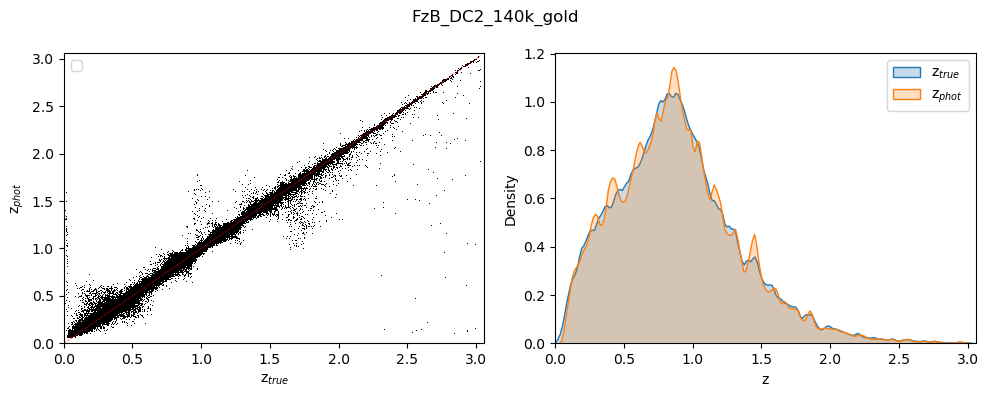

In [87]:
plot_old_valid(zphot,ztrue,'FzB_DC2_140k_gold')#,path_to_save=f'/home/iago/ic_cosmo/plots/DC2_i{mag}_scatter.png')

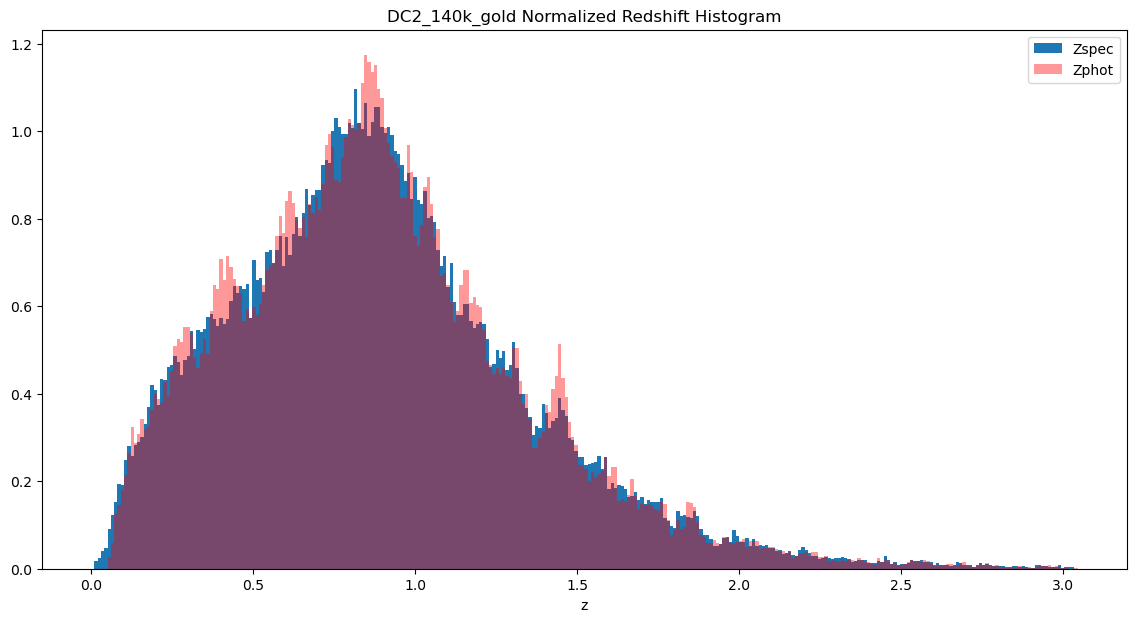

In [88]:
plt.figure(figsize=(14,7))
y = plt.hist(ztrue,bins=zgrid,label='Zspec', density=True)
t = plt.hist(zphot,bins=zgrid,label='Zphot', alpha=0.4, density=True,color='red')
#t = plt.hist(zphot_,bins=zgrid,label='Zphot_mixed', histtype = 'step', density=True)
plt.title('DC2_140k_gold Normalized Redshift Histogram')
plt.xlabel('z')
#plt.xlim(0,1.4)
plt.legend()
#plt.savefig(f'/home/iago/ic_cosmo/plots/DC2_i{mag}_hist.png')

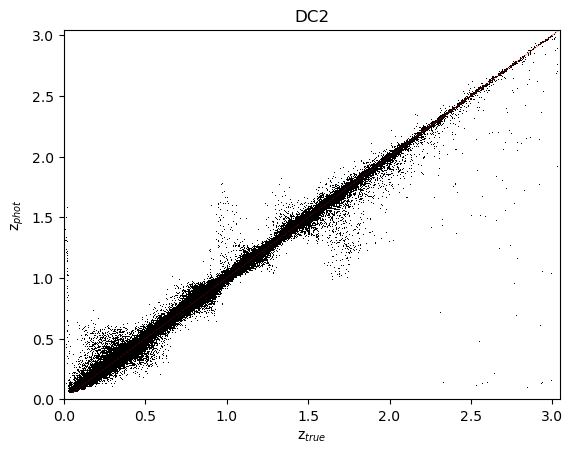

In [89]:
plt.plot(ztrue, zphot, 'k,')
plt.xlim(0,max(zphot))
plt.ylim(0,max(zphot))

plt.plot(zphot,zphot,'r--', linewidth =0.5,alpha=0.4)
plt.xlabel('z$_{true}$')
plt.ylabel('z$_{phot}$')
plt.title('DC2')
#plt.savefig(f'/home/iago/ic_cosmo/plots/DC2_i{mag}_scatter.png')
plt.show()

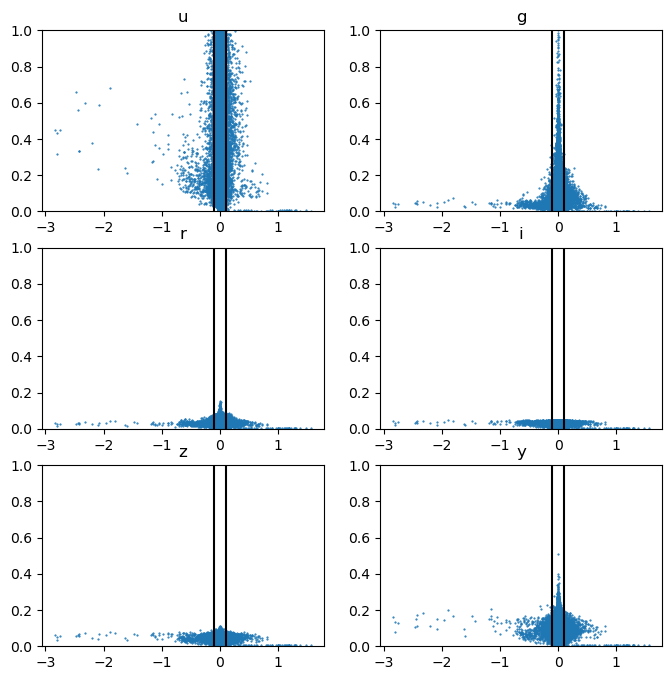

In [90]:
i=1
plt.figure(figsize=(8,8))
for band in bands:
    plt.subplot(3,2,i)
    plt.scatter(zphot-ztrue,catalog[f'mag_err_{band}_lsst'],s=0.3)
    plt.axvline(0.1, color='black')
    plt.axvline(-0.1, color='black')
    plt.title(band)
    plt.ylim(0,1)
    i+=1

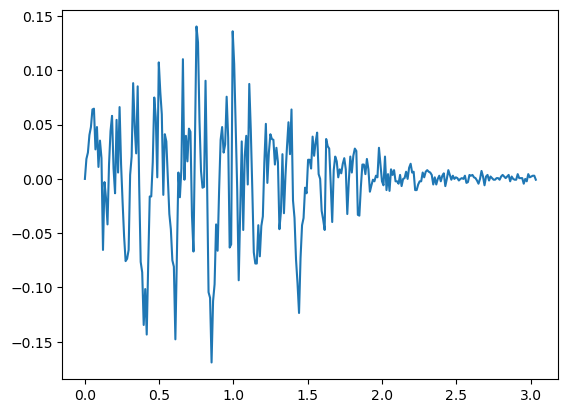

In [91]:
plt.plot(zgrid[:-1],y[0]-t[0])

In [92]:
#plot_pit_qq(pdfs,zgrid,ztrue,title='FzB_DC2_goldtest')

In [93]:
old_metrics_table(zphot,ztrue)

|Metric | |DC1 paper
|:---|---:|---:
|scatter |     0.0093 |  0.0154
|bias |   -0.00004 | -0.00027
|outlier rate |      0.015 |  0.020

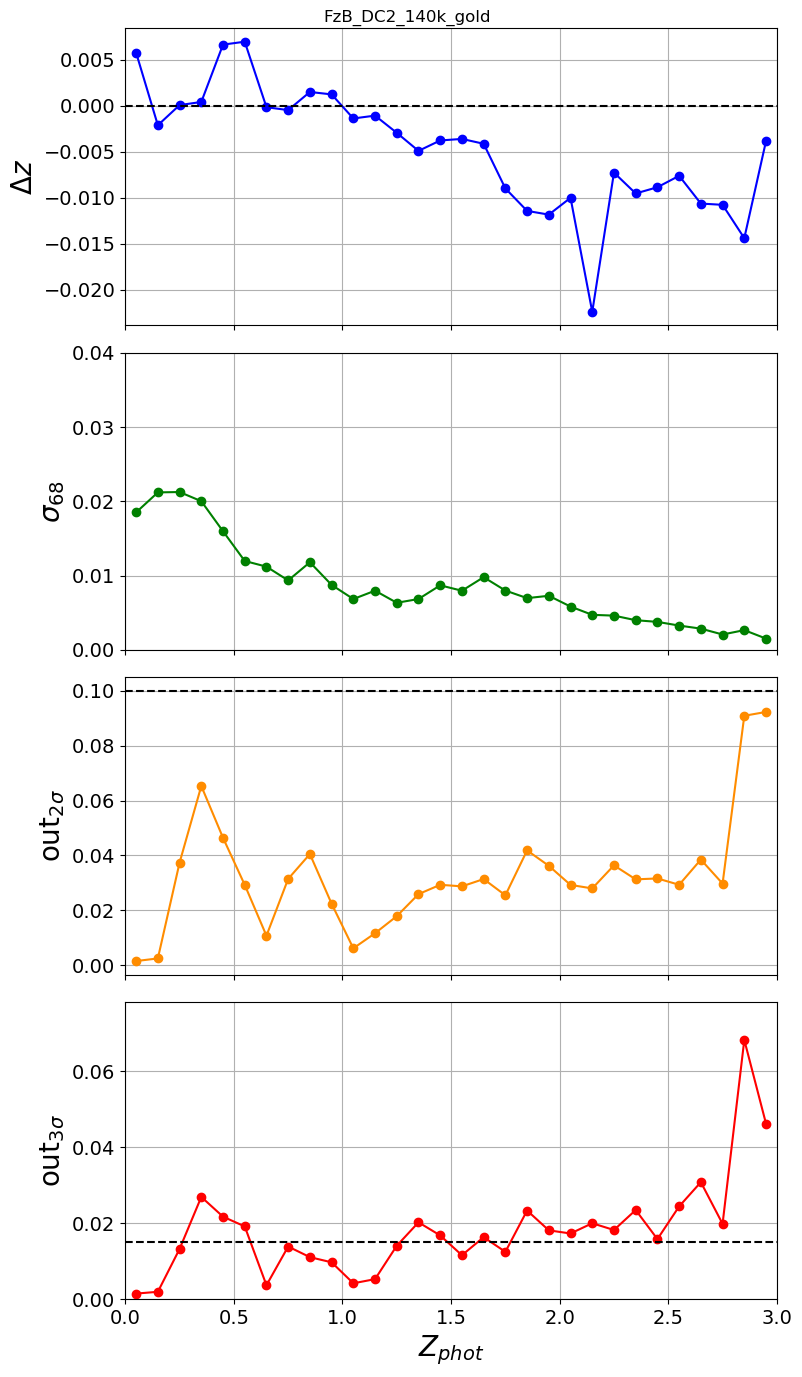

In [94]:
plot_metrics(ztrue,zphot,max(zphot),initial=0,title='FzB_DC2_140k_gold')#,path_to_save=f'/home/iago/ic_cosmo/plots/DC2_metrics_i{mag}.png')

# Bonus! Running the same data on TPz (still messed)

I run TPz on terminal using an environment with python 2.17 and the command 'runMLZ filepath'. It took 01:40:00

In [174]:
columns_map = {'redshift': '#zs', 
               'dec': 'dec',
               'ra': 'ra',
               'mag_u_lsst': 'u',
               'mag_err_u_lsst': 'eu',
               'mag_g_lsst': 'g',
               'mag_err_g_lsst': 'eg',
               'mag_r_lsst': 'r',
               'mag_err_r_lsst': 'er',
               'mag_i_lsst': 'i',
               'mag_err_i_lsst': 'ei',
               'mag_y_lsst': 'y',
               'mag_err_y_lsst': 'ey',
               'mag_z_lsst': 'z',
               'mag_err_z_lsst': 'ez',
               'galid': 'galid',
               'ug': 'u-g',
               'ug_err': 'eu-g',
               'gr': 'g-r',
               'gr_err': 'eg-r',
               'ri': 'r-i',
               'ri_err': 'er-i',
               'iz': 'i-z',
               'iz_err': 'ei-z',
               'zy': 'z-y',
               'zy_err': 'ez-y'
              
}

data = data.rename(columns=columns_map)


In [175]:
data

,g-r,eg-r,id,i-z,ei-z,eg,ei,er,eu,ey,...,u,y,z,#zs,r-i,er-i,u-g,eu-g,z-y,ez-y
1,0.315699,0.007944,1312500225,0.077675,0.008477,0.005824,0.005575,0.005403,0.033321,0.009905,...,23.202431,21.592501,21.638060,0.030609,0.185198,0.007763,0.985800,0.033827,0.045559,0.011785
2,0.174147,0.033231,1312500450,0.122187,0.047875,0.026059,0.025786,0.020620,0.306728,0.097963,...,25.644894,24.262041,24.195457,0.045475,0.147116,0.033017,1.005987,0.307833,-0.066584,0.105942
3,0.275715,0.013911,1312500675,0.048395,0.018623,0.010965,0.010116,0.008561,0.123833,0.032323,...,24.655771,23.041840,23.107073,0.065590,0.142187,0.013252,1.082401,0.124318,0.065233,0.035906
4,0.434650,0.056377,1312500900,0.127439,0.064814,0.047869,0.034883,0.029781,0.498633,0.127012,...,26.173477,24.545084,24.529957,0.065404,0.227051,0.045866,0.854380,0.500925,-0.015127,0.138261
5,0.409700,0.014604,1312501125,0.089149,0.016855,0.011905,0.009458,0.008458,0.155537,0.028244,...,24.904810,22.890232,22.965204,0.052629,0.222832,0.012689,1.217924,0.155992,0.074972,0.031501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141347,0.306469,0.057675,12016611194,-0.171865,0.091578,0.047302,0.039958,0.032999,3.383940,0.170498,...,28.253912,24.865582,24.980207,2.537769,0.191120,0.051823,2.947981,3.384271,0.114626,0.189366
141348,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,0.129267,...,24.674099,24.564243,24.624903,2.557191,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
141349,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,0.164621,...,24.415499,24.827410,24.705545,2.616157,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
141350,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,0.114559,...,25.356873,24.432663,24.294462,2.694391,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759


In [182]:
z = data.pop('#zs')

In [188]:
data.insert(loc=0,column='#zs',value=z)

In [189]:
data

,#zs,g-r,eg-r,id,i-z,ei-z,eg,ei,er,eu,...,r,u,y,z,r-i,er-i,u-g,eu-g,z-y,ez-y
1,0.030609,0.315699,0.007944,1312500225,0.077675,0.008477,0.005824,0.005575,0.005403,0.033321,...,21.900932,23.202431,21.592501,21.638060,0.185198,0.007763,0.985800,0.033827,0.045559,0.011785
2,0.045475,0.174147,0.033231,1312500450,0.122187,0.047875,0.026059,0.025786,0.020620,0.306728,...,24.464760,25.644894,24.262041,24.195457,0.147116,0.033017,1.005987,0.307833,-0.066584,0.105942
3,0.065590,0.275715,0.013911,1312500675,0.048395,0.018623,0.010965,0.010116,0.008561,0.123833,...,23.297655,24.655771,23.041840,23.107073,0.142187,0.013252,1.082401,0.124318,0.065233,0.035906
4,0.065404,0.434650,0.056377,1312500900,0.127439,0.064814,0.047869,0.034883,0.029781,0.498633,...,24.884447,26.173477,24.545084,24.529957,0.227051,0.045866,0.854380,0.500925,-0.015127,0.138261
5,0.052629,0.409700,0.014604,1312501125,0.089149,0.016855,0.011905,0.009458,0.008458,0.155537,...,23.277185,24.904810,22.890232,22.965204,0.222832,0.012689,1.217924,0.155992,0.074972,0.031501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141347,2.537769,0.306469,0.057675,12016611194,-0.171865,0.091578,0.047302,0.039958,0.032999,3.383940,...,24.999462,28.253912,24.865582,24.980207,0.191120,0.051823,2.947981,3.384271,0.114626,0.189366
141348,2.557191,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,...,24.566893,24.674099,24.564243,24.624903,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
141349,2.616157,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,...,24.396069,24.415499,24.827410,24.705545,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
141350,2.694391,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,...,24.352198,25.356873,24.432663,24.294462,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759


In [190]:
fraction = 0.7 # choose a value between 0 and 1

training_csv = data.sample(round(len(data)*fraction),random_state=40)
validation_csv = data.drop(training_csv.index)

In [191]:
training_csv = training_csv.sort_index()
training_csv

,#zs,g-r,eg-r,id,i-z,ei-z,eg,ei,er,eu,...,r,u,y,z,r-i,er-i,u-g,eu-g,z-y,ez-y
2,0.045475,0.174147,0.033231,1312500450,0.122187,0.047875,0.026059,0.025786,0.020620,0.306728,...,24.464760,25.644894,24.262041,24.195457,0.147116,0.033017,1.005987,0.307833,-0.066584,0.105942
4,0.065404,0.434650,0.056377,1312500900,0.127439,0.064814,0.047869,0.034883,0.029781,0.498633,...,24.884447,26.173477,24.545084,24.529957,0.227051,0.045866,0.854380,0.500925,-0.015127,0.138261
5,0.052629,0.409700,0.014604,1312501125,0.089149,0.016855,0.011905,0.009458,0.008458,0.155537,...,23.277185,24.904810,22.890232,22.965204,0.222832,0.012689,1.217924,0.155992,0.074972,0.031501
6,0.071089,0.490662,0.015836,1312501350,0.080200,0.017628,0.013202,0.009794,0.008744,0.184184,...,23.333149,25.089262,22.938166,23.027214,0.225735,0.013129,1.265451,0.184657,0.089048,0.032914
7,0.069619,0.522577,0.068093,1312501575,0.198673,0.065035,0.059078,0.036604,0.033860,0.982555,...,25.028233,26.910694,24.448503,24.512325,0.317234,0.049863,1.359884,0.984330,0.063822,0.128065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141347,2.537769,0.306469,0.057675,12016611194,-0.171865,0.091578,0.047302,0.039958,0.032999,3.383940,...,24.999462,28.253912,24.865582,24.980207,0.191120,0.051823,2.947981,3.384271,0.114626,0.189366
141348,2.557191,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,...,24.566893,24.674099,24.564243,24.624903,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
141349,2.616157,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,...,24.396069,24.415499,24.827410,24.705545,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
141350,2.694391,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,...,24.352198,25.356873,24.432663,24.294462,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759


In [192]:
validation_csv

,#zs,g-r,eg-r,id,i-z,ei-z,eg,ei,er,eu,...,r,u,y,z,r-i,er-i,u-g,eu-g,z-y,ez-y
1,0.030609,0.315699,0.007944,1312500225,0.077675,0.008477,0.005824,0.005575,0.005403,0.033321,...,21.900932,23.202431,21.592501,21.638060,0.185198,0.007763,0.985800,0.033827,0.045559,0.011785
3,0.065590,0.275715,0.013911,1312500675,0.048395,0.018623,0.010965,0.010116,0.008561,0.123833,...,23.297655,24.655771,23.041840,23.107073,0.142187,0.013252,1.082401,0.124318,0.065233,0.035906
9,0.086031,0.511183,0.023123,1312502025,0.135410,0.024057,0.019723,0.013381,0.012068,0.273260,...,23.805473,25.519108,23.304068,23.400873,0.269190,0.018019,1.202452,0.273971,0.096806,0.045533
12,0.087663,0.470646,0.032559,1312502703,0.140762,0.034858,0.027744,0.019134,0.017041,0.287635,...,24.239460,25.574932,23.794418,23.832363,0.266335,0.025622,0.864826,0.288970,0.037945,0.070197
17,0.086607,0.474798,0.042607,1312504059,0.205530,0.045975,0.036460,0.026083,0.022047,0.968862,...,24.542290,26.895451,24.067331,24.125134,0.211626,0.034152,1.878363,0.969548,0.057802,0.090281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141329,2.054565,0.069790,0.024706,12013092534,0.116953,0.044272,0.018636,0.023803,0.016219,0.112885,...,24.179779,24.554497,23.944056,24.109434,-0.046608,0.028804,0.304928,0.114413,0.165379,0.082185
141330,2.079202,0.174669,0.016598,12013098026,0.140520,0.026043,0.012851,0.014462,0.010504,0.086342,...,23.614019,24.260674,23.183693,23.494047,-0.020548,0.017874,0.471985,0.087293,0.310354,0.042619
141336,2.157745,-0.043240,0.011217,12013667540,-0.050415,0.021861,0.008067,0.011054,0.007794,0.034937,...,23.129696,23.256037,23.381330,23.332359,-0.152248,0.013525,0.169580,0.035856,-0.048971,0.047751
141340,2.168364,0.165026,0.025331,12014278123,0.156364,0.040464,0.019746,0.022335,0.015866,0.134287,...,24.152996,24.744366,23.720245,23.996874,-0.000242,0.027397,0.426344,0.135731,0.276628,0.068564


In [193]:
training_csv.to_csv('/home/iago.dias/IC_Photo-z/Iago/samples/training_DC2_goldtest', sep =' ', index=False)
validation_csv.to_csv('/home/iago.dias/IC_Photo-z/Iago/samples/validation_DC2_goldtest', sep =' ', index=False)

In [194]:
z_max

3.030610483909146

In [195]:
z_min

0.00922610874119556

# Results

The file with 1 means regression and with 0 means classification.

In [57]:

column_names = ['ztrue','zmode0','zmean1','zConf0','zConf1','err0','err1']
result = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/results/results_DC2_goldtest.1.mlz',names = column_names, header = None, skiprows =1, sep =' ')


In [58]:
ztrue = result['ztrue']
zphot = result['zmean1']

In [59]:
result

,ztrue,zmode0,zmean1,zConf0,zConf1,err0,err1
0,0.0306,0.0945,0.3169,0.3914,0.0000,0.0994,0.2807
1,0.0656,0.1096,0.4233,0.3186,0.0000,0.0671,0.3774
2,0.0860,0.1196,0.3385,0.3271,0.0000,0.1434,0.2201
3,0.0877,0.1949,0.2458,0.4897,0.1791,0.0652,0.0678
4,0.0866,0.1397,0.2367,0.4781,0.1015,0.0571,0.1159
...,...,...,...,...,...,...,...
39848,2.0546,0.9829,1.3545,0.3013,0.0000,0.7559,0.4123
39849,2.0792,1.6052,1.2577,0.3651,0.0000,0.6055,0.3765
39850,2.1577,2.1774,1.8756,0.3215,0.1405,0.3532,0.3720
39851,2.1684,2.0569,1.5014,0.3659,0.0000,1.0440,0.5481


In [60]:
result[result['ztrue']<0.7]

,ztrue,zmode0,zmean1,zConf0,zConf1,err0,err1
0,0.0306,0.0945,0.3169,0.3914,0.0000,0.0994,0.2807
1,0.0656,0.1096,0.4233,0.3186,0.0000,0.0671,0.3774
2,0.0860,0.1196,0.3385,0.3271,0.0000,0.1434,0.2201
3,0.0877,0.1949,0.2458,0.4897,0.1791,0.0652,0.0678
4,0.0866,0.1397,0.2367,0.4781,0.1015,0.0571,0.1159
...,...,...,...,...,...,...,...
39457,0.6563,0.6968,0.6230,0.2972,0.1716,0.1704,0.1169
39458,0.6492,0.6115,0.6227,0.2065,0.2184,0.1644,0.1562
39459,0.6820,2.3229,1.0450,0.1213,0.0122,1.2812,0.7860
39460,0.6570,0.6567,0.7411,0.2579,0.0843,0.1921,0.1590


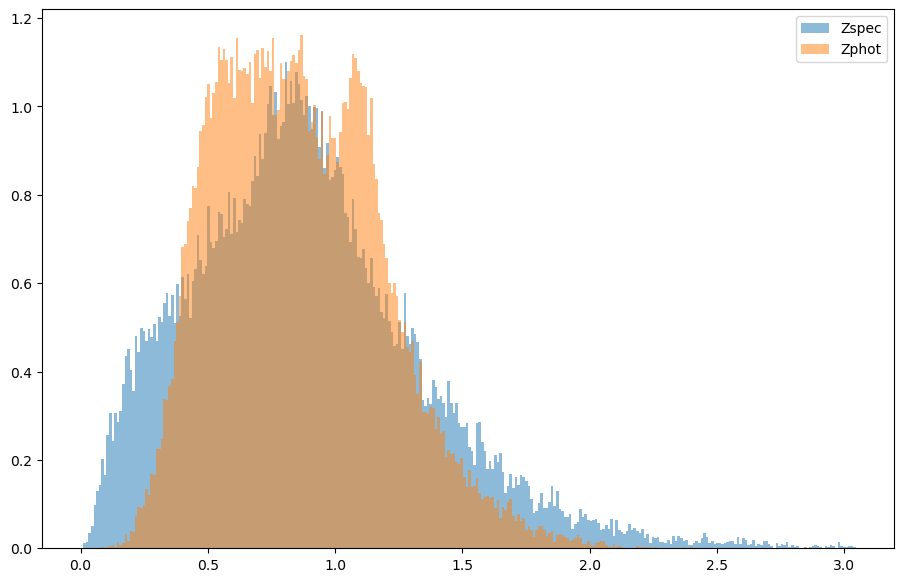

In [61]:
plt.figure(figsize=(11,7))
y = plt.hist(ztrue,bins=zgrid,label='Zspec',alpha=0.5, density=True)
t = plt.hist(zphot,bins=zgrid,label='Zphot',alpha=0.5,density=True)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


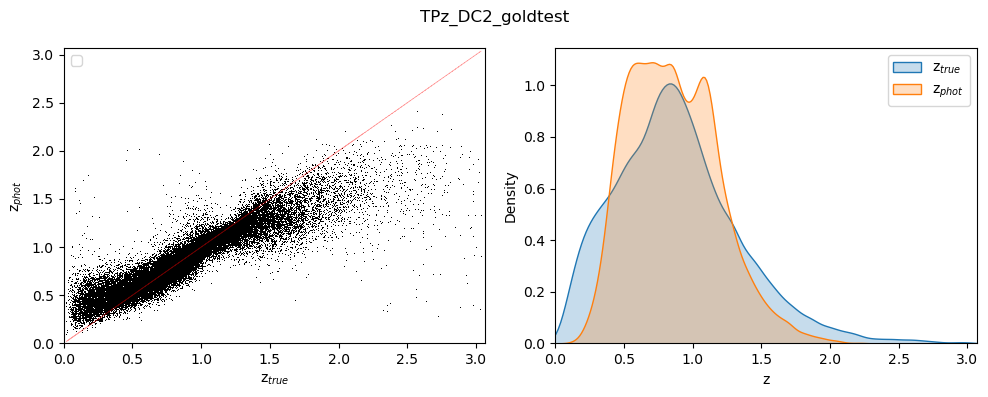

In [62]:
plot_old_valid(ztrue=ztrue,photoz=zphot,title='TPz_DC2_goldtest')

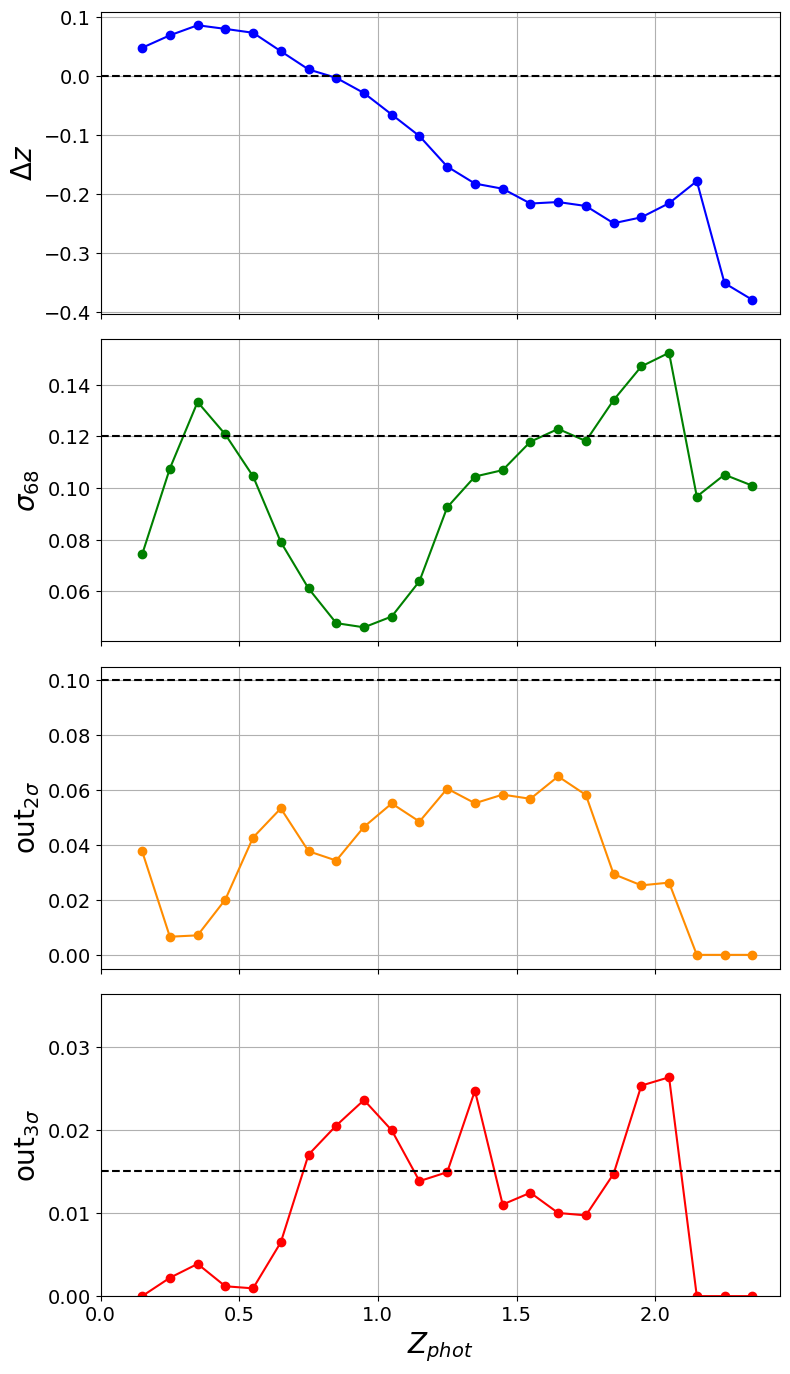

In [63]:
plot_metrics(ztrue,zphot,max(zphot),initial=0.1)